In [11]:
import torch
import torchvision
import pandas as pd
from torchvision.transforms import transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [12]:
# load data
train = pd.read_csv("../input/train.csv", dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

In [13]:
# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long
# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

In [14]:
 # batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [15]:
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [16]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)   # linear function 1
        self.relu_1 = nn.ReLU()                        # non-linearity 1
        
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)  # linear function 2
        self.tanh_2 = nn.Tanh()                        # non-linearity 2
        
        self.fc_3 = nn.Linear(hidden_dim, hidden_dim)  # linear function 3
        self.elu_3 = nn.ELU()                          # non-linearity 3
        
        self.fc_4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out = self.fc_1(x)
        out = self.relu_1(out)
        out = self.fc_2(out)
        out = self.tanh_2(out)
        out = self.fc_3(out)
        out = self.elu_3(out)
        out = self.fc_4(out)
        return out
        

In [17]:
# Instantiate Model Class
input_dim = 28*28                                      # size of image px*px
hidden_dim =150                                        # hyperparameter
output_dim = 10                                        # labels 0,1,2,3,4,5,6,7,8,9
model = ANNModel(input_dim, hidden_dim, output_dim) # create logistic regression model
error = nn.CrossEntropyLoss()                          # Cross Entropy Loss 
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # SGD Optimizer 

In [18]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.view(-1, 28*28))  # Define variables
        labels = Variable(labels)
        optimizer.zero_grad()                     # Clear gradients
        outputs = model(train)                    # Forward propagation
        loss = error(outputs, labels)             # Calculate softmax and cross entropy loss
        loss.backward()                           # Calculate gradients
        optimizer.step()                          # Update parameters
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                outputs = model(test)                     # Forward propagation
                predicted = torch.max(outputs.data, 1)[1] # Get predictions from the maximum value
                total += len(labels)                      # Total number of labels
                correct += (predicted == labels).sum()    # Total correct predictions
                
            accuracy = 100 * correct / float(total)
            loss_list.append(loss.data)                   # store loss 
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.7594375014305115  Accuracy: 79.41666412353516%
Iteration: 1000  Loss: 0.46381881833076477  Accuracy: 87.89286041259766%
Iteration: 1500  Loss: 0.24178847670555115  Accuracy: 89.76190185546875%
Iteration: 2000  Loss: 0.2905295193195343  Accuracy: 90.71428680419922%
Iteration: 2500  Loss: 0.30996936559677124  Accuracy: 91.88095092773438%
Iteration: 3000  Loss: 0.11604287475347519  Accuracy: 92.75%
Iteration: 3500  Loss: 0.24713543057441711  Accuracy: 93.41666412353516%
Iteration: 4000  Loss: 0.06563415378332138  Accuracy: 93.86904907226562%
Iteration: 4500  Loss: 0.3227352201938629  Accuracy: 94.30952453613281%
Iteration: 5000  Loss: 0.10071825981140137  Accuracy: 94.53571319580078%
Iteration: 5500  Loss: 0.1974164843559265  Accuracy: 94.53571319580078%
Iteration: 6000  Loss: 0.20974867045879364  Accuracy: 95.05952453613281%
Iteration: 6500  Loss: 0.09431729465723038  Accuracy: 95.32142639160156%
Iteration: 7000  Loss: 0.11846356093883514  Accuracy: 95.58333587646

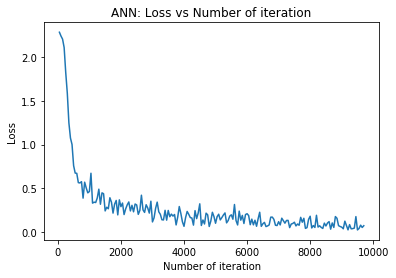

In [19]:
# visualization
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()